In [1]:
import os
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.datasets.folder import default_loader
from torchvision import transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import time
import copy
from tqdm import tqdm

In [2]:
batch_size = 32


train_dir = "/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/train"
val_dir = "/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/val"
test_dir = "/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/test"

transform = transforms.Compose(
                [
                    # transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                ]
            )

train_data = ImageFolder(train_dir, transform=transform, loader=default_loader)
val_data = ImageFolder(val_dir, transform=transform, loader=default_loader)
test_data = ImageFolder(test_dir, transform=transform, loader=default_loader)

image_datasets = {'train': train_data, 'validation': val_data}


In [3]:
def START_seed():
    seed = 9
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [4]:
# load dataset
START_seed()
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers = 8)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True, num_workers = 8)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers = 8)

dataloaders = {
    'train': train_loader, 
    'validation':val_loader
}

images.shape: torch.Size([32, 3, 224, 224])


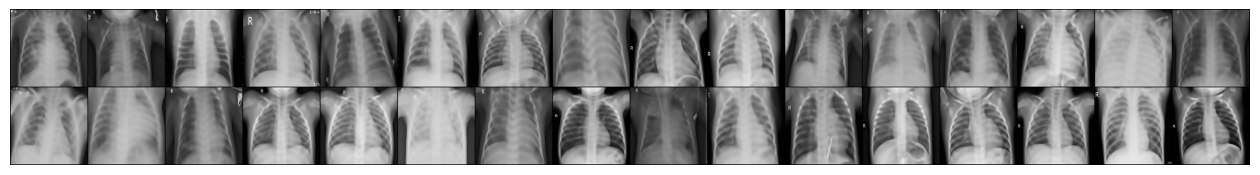

In [5]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [6]:
# Loss and optimizer
lr=1e-5
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [7]:
def train_swin(model, criterion, optimizer, num_epochs=3):
    best_model_wts = None
    best_acc = 0.0
    start_time = time.time()
    train_losses_per_epochs = []
    val_losses_per_epochs = []
    train_acc_per_epochs = []
    val_acc_per_epochs = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_losses_per_epochs.append(epoch_loss)
                train_acc_per_epochs.append(epoch_acc.item())
            else:
                val_losses_per_epochs.append(epoch_loss)
                val_acc_per_epochs.append(epoch_acc.item())

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, "swin_denoised.pth")

    print("Time:", (time.time() - start_time))
    return model, train_losses_per_epochs, val_losses_per_epochs, train_acc_per_epochs, val_acc_per_epochs

In [8]:
def test_best_model(model, test_loader, criterion, best_model_path):
    # Load the best model
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with tqdm(test_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        accuracy = 100. * correct / total
        print('Test loss: {:.4f} Accuracy: {:.2f}%'.format(test_loss/(batch_idx+1), accuracy))

In [9]:
from torchvision.models import swin_v2_b,  Swin_V2_B_Weights

swin_model = swin_v2_b(weights=None)

# for param in model_s.parameters(): #freeze model
#     param.requires_grad = False

n_inputs = swin_model.head.in_features
swin_model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(512, 2)
)
swin_model = swin_model.to(device=device)

optimizer_s = torch.optim.Adam(swin_model.parameters(), lr= lr)
# Number of parameters
total_params = sum(p.numel() for p in swin_model.parameters())
print(total_params)

87432698


In [10]:
swin_trained, train_losses_per_epochs, val_losses_per_epochs, train_acc_per_epochs, val_acc_per_epochs = train_swin(swin_model, criterion, optimizer_s, num_epochs=20)

Epoch 1/20
----------
train loss: 0.7424, acc: 0.5523
validation loss: 0.6129, acc: 0.6250
Epoch 2/20
----------
train loss: 0.5101, acc: 0.7556
validation loss: 0.7775, acc: 0.7500
Epoch 3/20
----------
train loss: 0.3948, acc: 0.8363
validation loss: 0.7437, acc: 0.6875
Epoch 4/20
----------
train loss: 0.3142, acc: 0.8775
validation loss: 0.8863, acc: 0.5625
Epoch 5/20
----------
train loss: 0.2713, acc: 0.8984
validation loss: 0.8988, acc: 0.5625
Epoch 6/20
----------
train loss: 0.2523, acc: 0.9051
validation loss: 0.8886, acc: 0.6250
Epoch 7/20
----------
train loss: 0.2328, acc: 0.9120
validation loss: 0.5120, acc: 0.8750
Epoch 8/20
----------
train loss: 0.2067, acc: 0.9214
validation loss: 0.8167, acc: 0.6875
Epoch 9/20
----------
train loss: 0.1870, acc: 0.9310
validation loss: 0.5910, acc: 0.6875
Epoch 10/20
----------
train loss: 0.1888, acc: 0.9319
validation loss: 0.5029, acc: 0.6875
Epoch 11/20
----------
train loss: 0.1663, acc: 0.9346
validation loss: 0.8180, acc: 0.75

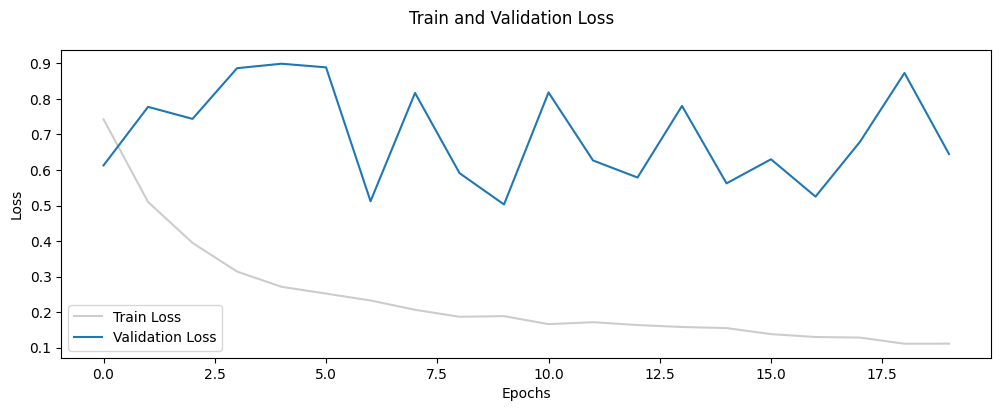

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Train and Validation Loss")
ax.plot(
    train_losses_per_epochs,
    alpha=0.2,
    label="Train Loss",
    color="black",
)
ax.plot(val_losses_per_epochs, label="Validation Loss")


# Set x-label and y-label
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
fig.savefig("Train_and_Validation_Loss_Swin")

_ = ax.legend()

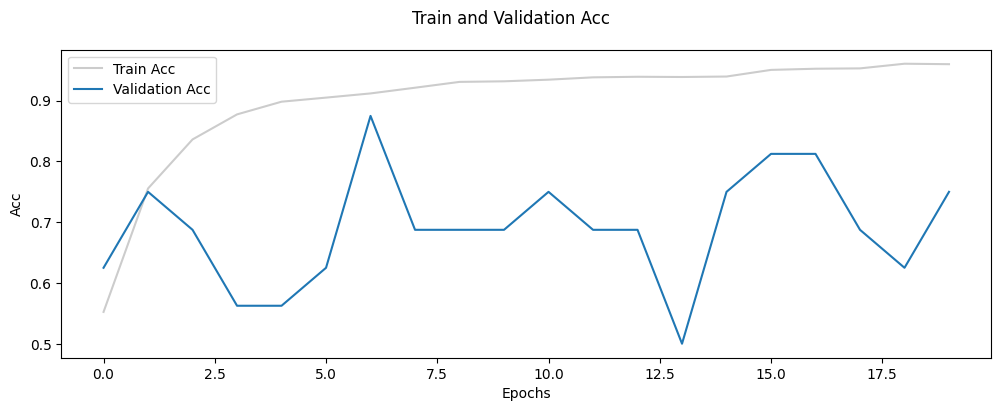

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Train and Validation Acc")
ax.plot(
    train_acc_per_epochs,
    alpha=0.2,
    label="Train Acc",
    color="black",
)
ax.plot(val_acc_per_epochs, label="Validation Acc")


# Set x-label and y-label
ax.set_xlabel("Epochs")
ax.set_ylabel("Acc")
fig.savefig("Train_and_Validation_Acc_Swin")

_ = ax.legend()

In [13]:
# Usage example:

# Assuming you have a model, test_loader, and best_model_path defined

best_swin_path = '/home/branislava.jankovic/Desktop/denoising-pneumonia/swin_denoised.pth'  # Replace with the actual path and filename of the best model

test_best_model(model=swin_model, test_loader=test_loader, criterion=criterion, best_model_path=best_swin_path)


100%|██████████| 20/20 [00:02<00:00,  8.80batch/s]

Test loss: 0.3969 Accuracy: 81.25%
